# Modelització

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

In [2]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV #, KFold
# from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, explained_variance_score
from sklearn.metrics import make_scorer, r2_score, mean_squared_error, mean_absolute_error, median_absolute_error

In [3]:
pd.set_option('display.width', 100)

### Training i test split

In [4]:
X_train = pd.read_csv('X_train.csv', index_col=[0,1])
X_test = pd.read_csv('X_test.csv', index_col=[0,1])
y_train = pd.read_csv('y_train.csv').squeeze()
y_test = pd.read_csv('y_test.csv').squeeze()

In [5]:
X_train.head(2)

,,track_number,acousticness,danceability,energy,liveness,loudness,tempo,valence,duration,taylors_version,...,Red,Red (Taylor's Version),Speak Now,Speak Now (Taylor's Version),Speak Now World Tour Live,Taylor Swift,evermore,folklore,reputation,reputation Stadium Tour Surprise Song Playlist
name,album,,,,,,,,,,,,,,,,,,,,,
"You're On Your Own, Kid",Midnights,0.088889,-0.779037,0.689602,0.322115,-3.962381,0.399829,0.372703,0.389355,0.102381,False,...,False,False,False,False,False,False,False,False,False,False
Fearless,Fearless,0.133333,-2.302505,0.542813,0.716346,-1.666484,0.822298,0.228743,0.474382,0.204814,False,...,False,False,False,False,False,False,False,False,False,False


In [6]:
y_train.to_frame().T

,0,1,2,3,4,5,6,7,8,9,...,410,411,412,413,414,415,416,417,418,419
popularity,0.67,0.43,0.78,0.65,0.54,0.69,0.51,0.79,0.3,0.33,...,0.33,0.5,0.54,0.68,0.71,0.64,0.71,0.76,0.45,0.7


### Useful Functions

In [7]:
def compute_metrics(y_pred):
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mean_abs_e = mean_absolute_error(y_test, y_pred)
    median_abs_e = median_absolute_error(y_test, y_pred)
    return r2, mse, mean_abs_e, median_abs_e

In [8]:
def plot_predictions(model):
    y_pred = model.predict(X_test)

    if hasattr(model, 'oob_score_'):
        print(f'OOB Score:      {model.oob_score_:.4f}')

    r2, mse, mean_abs_e, median_abs_e = compute_metrics(y_pred)
    print(f'r2 score:       {r2:.4f}\n' +
          f'mse:            {mse:.4f}\n' +
          f'mean abs err:   {mean_abs_e:.4f}\n' +
          f'median abs err: {median_abs_e:.4f}')

    predictions_df = pd.DataFrame({'popularity': y_test.values, 'y_pred': y_pred}, index=X_test.index)
    album_names = predictions_df.index.get_level_values(1).unique()

    for album in album_names:
        subset = predictions_df[predictions_df.index.get_level_values(1) == album]
        plt.scatter(subset['popularity'], subset['y_pred'], label=album, alpha=0.5)

    plt.plot([0, 1], [0, 1], color='black', alpha=0.5, ls=':')
    plt.xlim(0.25, 0.95)
    plt.ylim(0.25, 0.95)
    plt.xlabel("Real popularity")
    plt.ylabel("Predicted popularity")

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

## Model Lineal

In [9]:
from sklearn.linear_model import LinearRegression,  RidgeCV, LassoCV # , Rigde, Lasso

In [10]:
lr = LinearRegression()

lr.fit(X_train,y_train)

y_pred = lr.predict(X_test)

weights = lr.coef_
intercept = lr.intercept_

df = pd.DataFrame(weights, index=X_train.columns, columns=['coef.']).T
df['-'] = ''
df['intercept'] = intercept
df

,track_number,acousticness,danceability,energy,liveness,loudness,tempo,valence,duration,taylors_version,...,Speak Now,Speak Now (Taylor's Version),Speak Now World Tour Live,Taylor Swift,evermore,folklore,reputation,reputation Stadium Tour Surprise Song Playlist,-,intercept
coef.,-0.113498,0.005426,-0.027732,0.02015,-0.003302,0.079554,-0.029391,0.016429,0.031281,0.07847,...,-0.119219,0.016933,0.011987,-0.07171,0.104856,0.073816,0.179329,-0.076948,,0.595375


Molt important veure quins són els pesos dels coeficients 'album', ja que quan predim no en posarem

In [11]:
album_idx = 15

df = pd.DataFrame(weights[album_idx:], index=X_train.columns[album_idx:], columns=['coef.']).T
df['-'] = ''
df['intercept'] = intercept
df

,1989,1989 (Taylor's Version),Fearless,Fearless (Taylor's Version),Live From Clear Channel Stripped 2008,Lover,Midnights,Red,Red (Taylor's Version),Speak Now,Speak Now (Taylor's Version),Speak Now World Tour Live,Taylor Swift,evermore,folklore,reputation,reputation Stadium Tour Surprise Song Playlist,-,intercept
coef.,-0.048986,0.062728,-0.158632,-0.0137,-0.119115,0.169663,0.143025,-0.166535,0.012509,-0.119219,0.016933,0.011987,-0.07171,0.104856,0.073816,0.179329,-0.076948,,0.595375


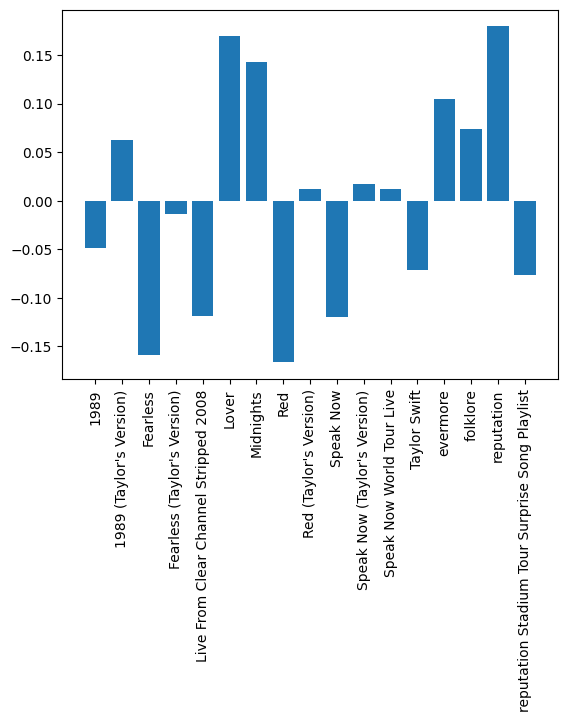

In [12]:
plt.bar(X_test.columns[album_idx:], weights[album_idx:])
plt.xticks(rotation=90)
plt.show()

Veiem que els àlbums més recents (Midnights, evermore, folklore, Lover)...

r2 score:       0.8249
mse:            0.0033
mean abs err:   0.0438
median abs err: 0.0332


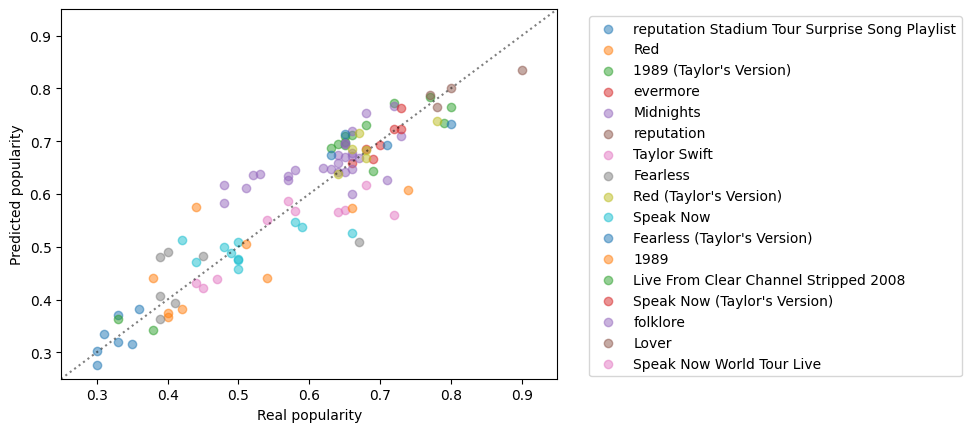

In [13]:
plot_predictions(lr)

Cross validation

In [14]:
from sklearn.model_selection import LeaveOneOut

N = len(X_train)

lr_cv = LinearRegression()
lr_cv.fit(X_train, y_train)
folds_r2 = cross_val_score(lr_cv, X_train, y_train, cv=5, scoring='r2')
lr_r2 = np.mean(folds_r2)
print(lr_r2)

0.8348076520197057


Veiem que el model lineal de moment explica molta variablitat.

#### Regularització

Ridge:

In [15]:
lambdas = [1e-10, 1e-5, 1e-3, 1e-2, 0.1, 0.5, 0.7, 0.8, 0.9, 1, 2, 10, 100, 200]

In [16]:
ridge_cv = RidgeCV(alphas=lambdas, cv=5)
ridge_cv.fit(X_train, y_train)
print('Best Lambda:', ridge_cv.alpha_)
print('R2 SCORE: ', ridge_cv.best_score_)

Best Lambda: 0.7
R2 SCORE:  0.837498030294487


In [17]:
abs(ridge_cv.coef_ - lr.coef_)

array([0.00621028, 0.00172488, 0.00682037, 0.00816032, 0.0002921 ,
       0.03045679, 0.00164804, 0.00428367, 0.01414108, 0.00065728,
       0.00599381, 0.00071535, 0.00472581, 0.00177608, 0.00358503,
       0.00090032, 0.00503101, 0.00838937, 0.00133943, 0.01374127,
       0.00956142, 0.00944612, 0.00292213, 0.0001905 , 0.00970612,
       0.00453936, 0.00432148, 0.00987503, 0.00451667, 0.00372601,
       0.01119384, 0.00342598])

No hi ha hagut massa diferència

#### Lasso

Ridge:

In [18]:
lambdas = [1e-10,1e-5, 1e-4,1e-4,1e-3, 1e-2, 1e-1, 0.2, 0.3, 0.5, 0.7, 0.8, 1, 2, 10, 100, 200]

In [19]:
lasso_cv = LassoCV(alphas=lambdas, cv=5)
lasso_cv.fit(X_train, y_train)
print('Best Lambda:', lasso_cv.alpha_)
lasso_r2 = r2_score(y_train, lasso_cv.predict(X_train))
print('R2 SCORE: ', lasso_r2)

Best Lambda: 0.0001
R2 SCORE:  0.8612130785196459


/home/gerard/Escriptori/UPC/22_2n-Q2/AA1/AA1-env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007218723045023578, tolerance: 0.0007785835416666666
  model = cd_fast.enet_coordinate_descent_gram(
/home/gerard/Escriptori/UPC/22_2n-Q2/AA1/AA1-env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009739510596251222, tolerance: 0.0007995880952380952
  model = cd_fast.enet_coordinate_descent_gram(
/home/gerard/Escriptori/UPC/22_2n-Q2/AA1/AA1-env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011019235058850718, tolerance: 0.0008038925892857144
  model = cd_fas

In [20]:
abs(lasso_cv.coef_ - lr.coef_)

array([0.00385159, 0.0017012 , 0.0078133 , 0.00260309, 0.00037063,
       0.01791663, 0.00389642, 0.00677099, 0.01770374, 0.02271746,
       0.0346677 , 0.00076231, 0.01266247, 0.0169976 , 0.01211512,
       0.00997609, 0.01760326, 0.01337506, 0.0103796 , 0.05572341,
       0.00372272, 0.00085296, 0.01037474, 0.01250859, 0.01543957,
       0.01154002, 0.04271891, 0.01687457, 0.00638047, 0.00716471,
       0.00295837, 0.04590363])

Tampoc hi ha hagut massa diferència

## Random forest i Decision tree

In [21]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [22]:
rf = RandomForestRegressor(oob_score=True)
model_rf = rf.fit(X_train, y_train)

OOB Score:      0.8253
r2 score:       0.7662
mse:            0.0044
mean abs err:   0.0460
median abs err: 0.0288


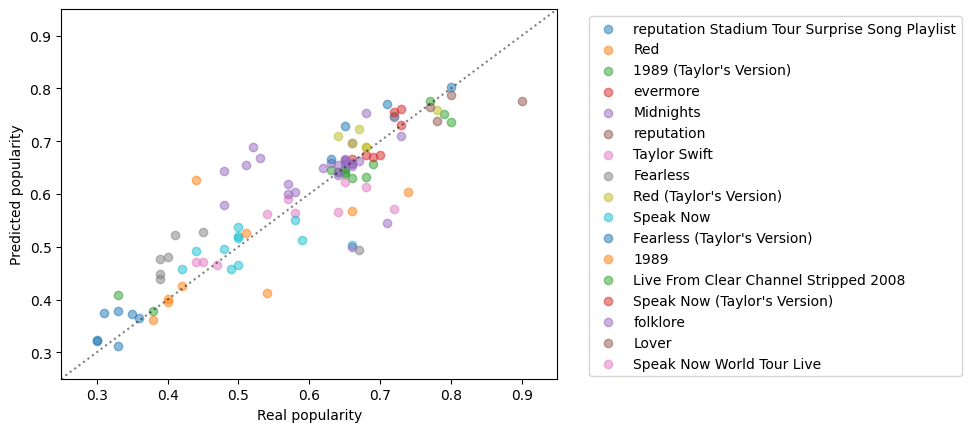

In [23]:
plot_predictions(rf)

MOLT baix error -> Però segurament és degut a overfitting (salt entre r2_score i OOB score)
La precisió pel OOB set és bastant bona, però.

Podriem afegir GridSearch (tant al DecisionTree com al RandomForest) !

### GridSearch per Decision Tree

Anem a veure si un Decision Tree SOL és capaç de fer una bona regressió.

In [24]:
scoring = {
    'r2': make_scorer(r2_score),
    'neg_mean_absolute_error': make_scorer(mean_absolute_error, greater_is_better=False),
    'neg_mean_squared_error': make_scorer(mean_squared_error, greater_is_better=False)
}

In [25]:
param_grid = {
    'max_depth': [8, 10, 12],
    'min_samples_split': [2, 3, 4, 5],
    'min_samples_leaf': [1, 2, 3, 4],
    'max_features': [None],
    'criterion': ['squared_error'],
    'splitter': ['random'],
    'max_leaf_nodes': [15, 20, 25],
    'min_impurity_decrease': [0.0]
}

dt = DecisionTreeRegressor(random_state=42)

grid_search = GridSearchCV(dt, param_grid, cv=5, scoring=scoring, refit='r2', return_train_score=True, n_jobs=-1)

grid_search.fit(X_train, y_train)

best_dt = grid_search.best_estimator_

In [26]:
scoring_cols = [
    'param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf', 'param_max_features', 'param_criterion', 'param_splitter', 'param_max_leaf_nodes', 'param_min_impurity_decrease',
    'mean_test_r2', 'mean_test_neg_mean_absolute_error', 'mean_test_neg_mean_squared_error'
]

pd.DataFrame(grid_search.cv_results_).sort_values(by='mean_test_r2', ascending=False)[scoring_cols].head()

,param_max_depth,param_min_samples_split,param_min_samples_leaf,param_max_features,param_criterion,param_splitter,param_max_leaf_nodes,param_min_impurity_decrease,mean_test_r2,mean_test_neg_mean_absolute_error,mean_test_neg_mean_squared_error
68,10,2,2,None,squared_error,random,20,0.0,0.841932,-0.046737,-0.003743
70,10,4,2,None,squared_error,random,20,0.0,0.841932,-0.046737,-0.003743
69,10,3,2,None,squared_error,random,20,0.0,0.841932,-0.046737,-0.003743
91,10,5,3,None,squared_error,random,25,0.0,0.841433,-0.046643,-0.003751
90,10,4,3,None,squared_error,random,25,0.0,0.841433,-0.046643,-0.003751


r2 score:       0.7611
mse:            0.0045
mean abs err:   0.0473
median abs err: 0.0304


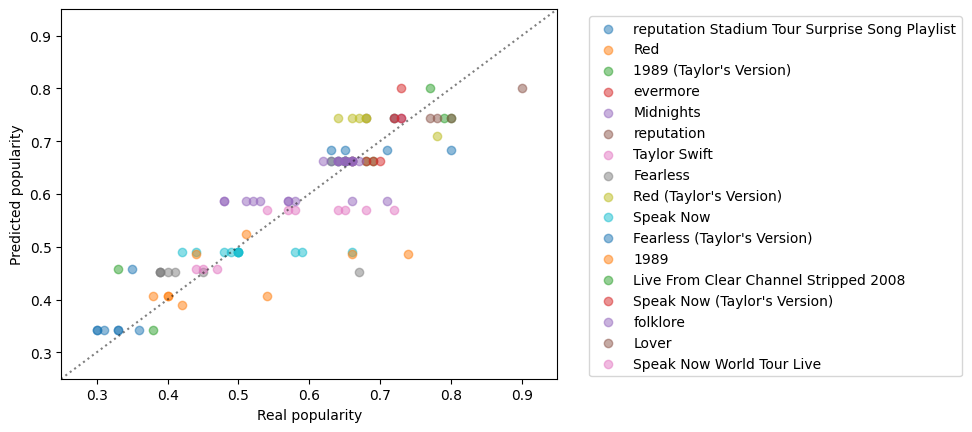

In [27]:
plot_predictions(best_dt)

Un bon decision tree! Quasi el 80% de la variància explicada per ambdós nivell de folds. És bàsicament tant bo com el RF sense Grid Search.

Coses a veure: hi ha poc overfitting perquè el r2 mitjà de la CV és quasi igual al de r2 de generalització?

### GridSearch per Random Forest

In [28]:
param_grid = {
    'n_estimators': [100, 200], # 200 is the best, tried for 10 and 100 too
    'max_depth': [9, 10, 11],  # values around 10. 8 was the best
    'min_samples_split': [8, 9, 10],  # values around 4
    'min_samples_leaf': [1, 2, 4],  # values around 7. 5 was best
    'max_features': [None],  # including None as it was the best in the previous run
    'criterion': ['squared_error'],
    'max_leaf_nodes': [40, 45, 50],
    'min_impurity_decrease': [0.0]
}

rf = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(rf, param_grid, scoring=scoring, cv=5, refit='r2', return_train_score=True, n_jobs=-1)

grid_search.fit(X_train, y_train)

best_estimator = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

In [29]:
scoring_cols = [
    'param_n_estimators', 'param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf', 'param_max_features', 'param_criterion', 'param_max_leaf_nodes', 'param_min_impurity_decrease',
    'mean_test_r2', 'mean_test_neg_mean_absolute_error', 'mean_test_neg_mean_squared_error'
]

pd.DataFrame(grid_search.cv_results_).sort_values(by='mean_test_r2', ascending=False)[scoring_cols].head()

,param_n_estimators,param_max_depth,param_min_samples_split,param_min_samples_leaf,param_max_features,param_criterion,param_max_leaf_nodes,param_min_impurity_decrease,mean_test_r2,mean_test_neg_mean_absolute_error,mean_test_neg_mean_squared_error
76,100,10,10,1,None,squared_error,45,0.0,0.837066,-0.047029,-0.003875
58,100,10,10,1,None,squared_error,40,0.0,0.837061,-0.047030,-0.003875
94,100,10,10,1,None,squared_error,50,0.0,0.837057,-0.047030,-0.003875
59,200,10,10,1,None,squared_error,40,0.0,0.837003,-0.046966,-0.003875
77,200,10,10,1,None,squared_error,45,0.0,0.836998,-0.046965,-0.003875


OOB Score:      0.8434
r2 score:       0.7781
mse:            0.0041
mean abs err:   0.0462
median abs err: 0.0309


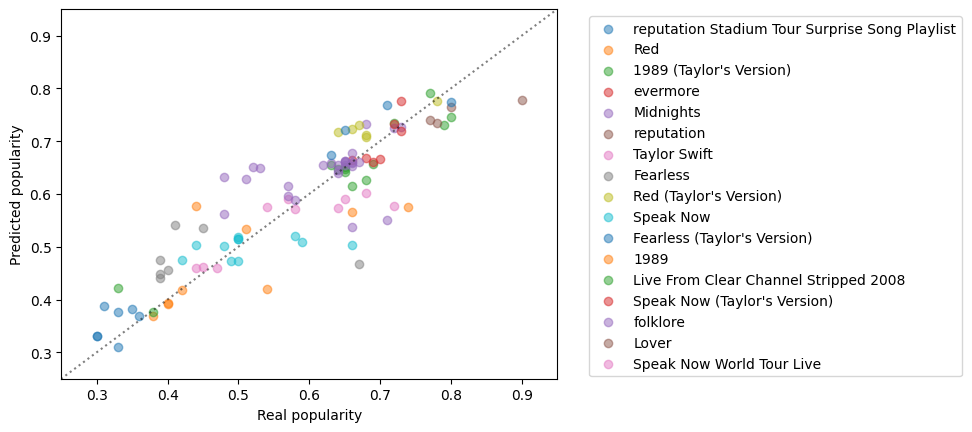

In [30]:
best_rf = RandomForestRegressor(oob_score=True,random_state=42,**best_params)
best_rf.fit(X_train, y_train)
plot_predictions(best_rf)

## SVM

In [31]:
from sklearn.svm import LinearSVR, SVR
from sklearn.neighbors import KNeighborsRegressor

In [32]:
results = pd.DataFrame(columns=['Kernel', 'C', 'epsilon', 'R2', 'MSE', 'median_absolute_error', 'mean_absolute_error'])

Baseline el KNN

r2 score:       0.7083
mse:            0.0054
mean abs err:   0.0561
median abs err: 0.0410


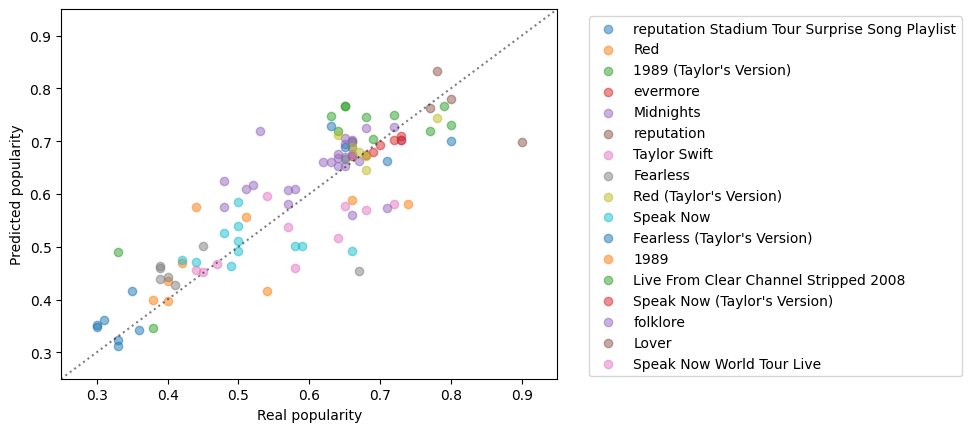

In [33]:
knn = KNeighborsRegressor()

knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)

plot_predictions(knn)

results.loc['KNN', :] = ['-', '-','-'] + list(compute_metrics(y_pred))

r2 score:       0.7891
mse:            0.0039
mean abs err:   0.0439
median abs err: 0.0264


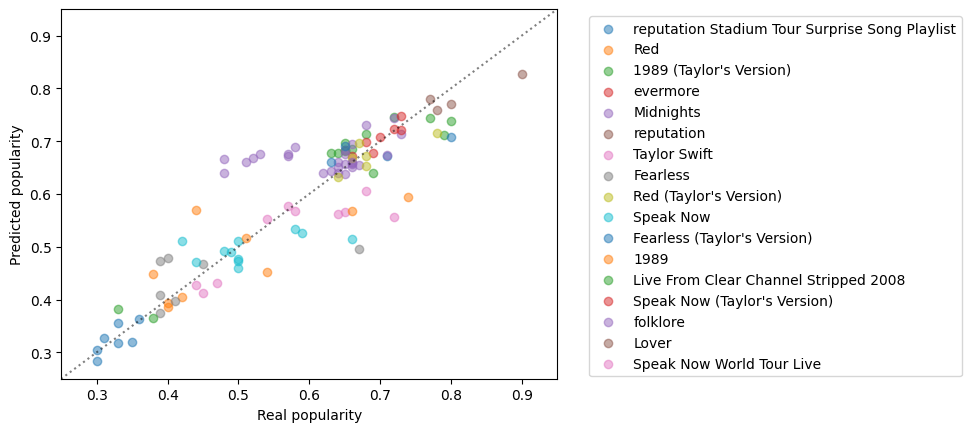

,Kernel,C,epsilon,R2,MSE,median_absolute_error,mean_absolute_error
LinearSVR-default,linear,1,0,0.789145,0.003935,0.043892,0.026376
KNN,-,-,-,0.708286,0.005444,0.056057,0.041


In [34]:
svm = LinearSVR(dual=True, max_iter=100000)

svm.fit(X_train,y_train)
y_pred = svm.predict(X_test)

results.loc['LinearSVR-default', :] = ['linear',1,0] + list(compute_metrics(y_pred))

plot_predictions(svm)

results.sort_values(by='R2', ascending=False)

SVM with parameters "gridsearch"?

In [35]:
cv_results = pd.DataFrame(columns=['Kernel', 'C', 'epsilon', 'R2', 'MSE', 'median_absolute_error', 'mean_absolute_error'])

Cs = [5, 10, 15, 20, 30] # values less than 10
epsilons = [0.0001, 0.00001, 0.000001, 0.0000001, 0.0]
for c in Cs:
    for epsilon in epsilons:
        svm = SVR(kernel='linear', C=c,epsilon=epsilon)
        svm.fit(X_train,y_train)
        y_pred = svm.predict(X_test)
        cv_results.loc['LinearSVR-{}-{}'.format(c,epsilon), :] = ['linear', c, epsilon] + list(compute_metrics(y_pred))
        
best = cv_results.sort_values(by='R2',ascending=False).iloc[0,:]
results.loc['LinearSVR-best',:] = best

In [36]:
cv_results.sort_values(by='R2', ascending=False).head()

,Kernel,C,epsilon,R2,MSE,median_absolute_error,mean_absolute_error
LinearSVR-5-0.0001,linear,5,0.0001,0.790332,0.003913,0.044017,0.025775
LinearSVR-15-0.0,linear,15,0.0,0.790288,0.003914,0.044056,0.02645
LinearSVR-10-0.0001,linear,10,0.0001,0.790093,0.003917,0.044076,0.025567
LinearSVR-20-0.0001,linear,20,0.0001,0.789807,0.003923,0.044192,0.025477
LinearSVR-30-0.0001,linear,30,0.0001,0.789746,0.003924,0.04415,0.025239


In [37]:
results.sort_values(by='R2', ascending=False)

,Kernel,C,epsilon,R2,MSE,median_absolute_error,mean_absolute_error
LinearSVR-best,linear,5,0.0001,0.790332,0.003913,0.044017,0.025775
LinearSVR-default,linear,1,0,0.789145,0.003935,0.043892,0.026376
KNN,-,-,-,0.708286,0.005444,0.056057,0.041


r2 score:       0.7903
mse:            0.0039
mean abs err:   0.0440
median abs err: 0.0258


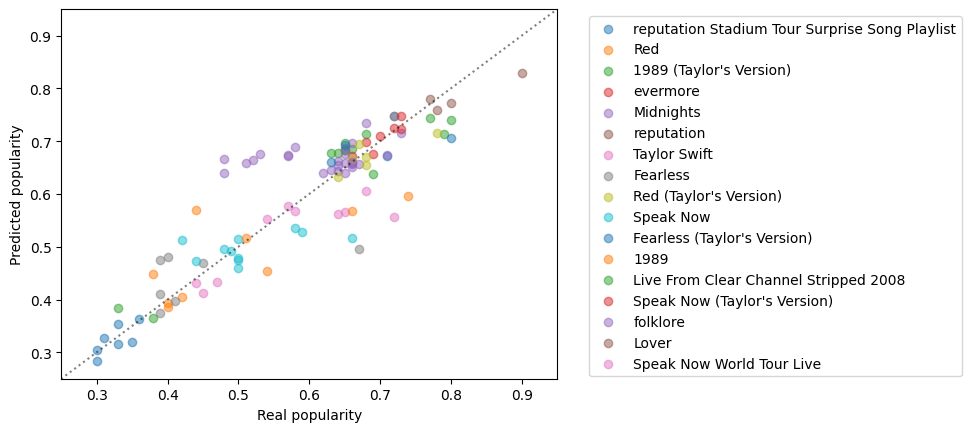

In [38]:
svm_best = SVR(kernel='linear', C=best['C'], epsilon=best['epsilon'])
svm_best.fit(X_train,y_train)
plot_predictions(svm_best)

## Non-linear SVR

r2 score:       0.7676
mse:            0.0043
mean abs err:   0.0534
median abs err: 0.0510


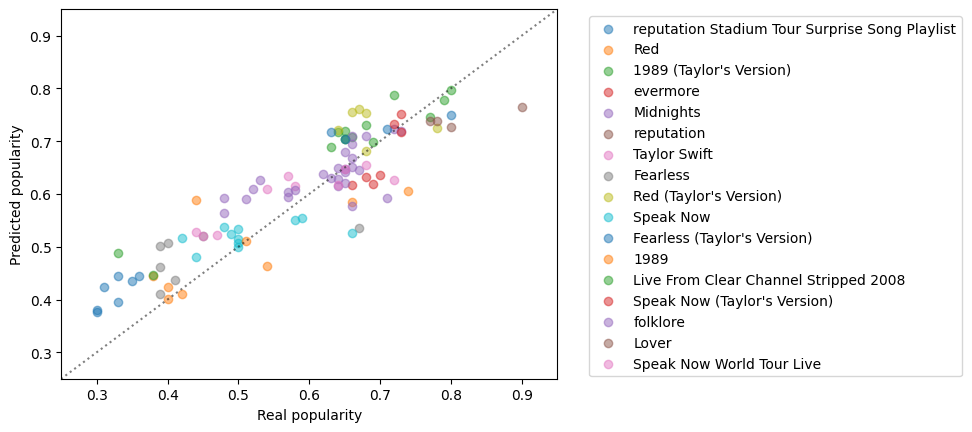

,Kernel,C,epsilon,R2,MSE,median_absolute_error,mean_absolute_error
LinearSVR-best,linear,5,0.0001,0.790332,0.003913,0.044017,0.025775
LinearSVR-default,linear,1,0,0.789145,0.003935,0.043892,0.026376
RBF-SVR-default,RBF,1,0,0.767557,0.004338,0.053407,0.050987
KNN,-,-,-,0.708286,0.005444,0.056057,0.041


In [39]:
svr_rbf = SVR(kernel='rbf')
svr_rbf.fit(X_train,y_train)
y_pred = svr_rbf.predict(X_test)

results.loc['RBF-SVR-default', :] = ['RBF',1,0]+ list(compute_metrics(y_pred))

plot_predictions(svr_rbf)

results.sort_values(by='R2', ascending=False)

In [40]:
Cs = [1, 2, 4, 5, 6, 10, 20]
epsilons = [0.02, 0.01, 0.005, 0.001, 0.0001, 0.00001, 0, 0]
for kernel_type in ['rbf', 'sigmoid', 'poly']:
    
    svr = SVR(kernel=kernel_type)
    svr.fit(X_train,y_train)
    y_pred = svr.predict(X_test)

    results.loc[kernel_type+'-SVR-default', :] = [kernel_type,1,0] + list(compute_metrics(y_pred))
    
    cv_results_rbf = pd.DataFrame(columns=['Kernel', 'C', 'epsilon', 'R2', 'MSE', 'median_absolute_error', 'mean_absolute_error'])
    for c in Cs:
        for epsilon in epsilons:
            svm = SVR(kernel=kernel_type, C=c,epsilon=epsilon)
            svm.fit(X_train,y_train)
            y_pred = svm.predict(X_test)
            cv_results_rbf.loc[kernel_type+'SVR-{}-{}'.format(c,epsilon), :] = [kernel_type, c, epsilon] + list(compute_metrics(y_pred))
            
    best = cv_results_rbf.sort_values(by='R2',ascending=False).iloc[0,:]
    results.loc[kernel_type+'SVR-best',:] = best

results.sort_values(by='R2', ascending=False).head(10)

,Kernel,C,epsilon,R2,MSE,median_absolute_error,mean_absolute_error
rbfSVR-best,rbf,5,0.01,0.838369,0.003016,0.03855,0.02655
polySVR-best,poly,20,0.005,0.793339,0.003857,0.046458,0.03235
LinearSVR-best,linear,5,0.0001,0.790332,0.003913,0.044017,0.025775
LinearSVR-default,linear,1,0,0.789145,0.003935,0.043892,0.026376
RBF-SVR-default,RBF,1,0,0.767557,0.004338,0.053407,0.050987
rbf-SVR-default,rbf,1,0,0.767557,0.004338,0.053407,0.050987
KNN,-,-,-,0.708286,0.005444,0.056057,0.041
poly-SVR-default,poly,1,0,0.594156,0.007574,0.072235,0.070175
sigmoidSVR-best,sigmoid,1,0.02,-346.8915,6.49226,1.78447,1.312263
sigmoid-SVR-default,sigmoid,1,0,-347.27011,6.499326,1.778059,1.318821


r2 score:       0.8384
mse:            0.0030
mean abs err:   0.0385
median abs err: 0.0266


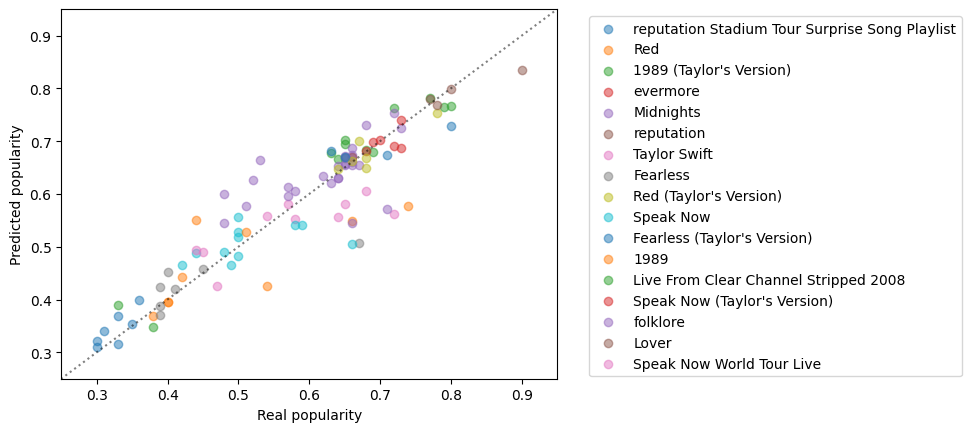

In [41]:
best_svm_params = results.loc[[results['R2'].idxmax()]]# best_svm = SVR(kernel=best['kernel'], C=best['C'], epsilon=best['epsilon'])
best_svm_all = SVR(kernel=best_svm_params['Kernel'].values[0], C=best_svm_params['C'].values[0], epsilon=best_svm_params['epsilon'].values[0])
best_svm_all.fit(X_train,y_train)
plot_predictions(best_svm_all)

In [48]:
support_vectors = best_svm_all.support_vectors_
dual_coef = best_svm_all.dual_coef_

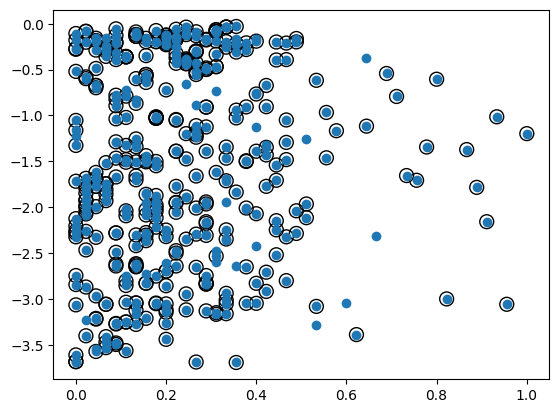

In [54]:
plt.scatter(support_vectors[:, 0], support_vectors[:, 1], s=100, facecolors='none', edgecolors='k', marker='o')
plt.scatter(X_train.iloc[:, 0], X_train.iloc[:, 1])
plt.show()

## Using boosting

We combine boosting with gridsearch to obtain the best estimators possible

In [42]:
from sklearn.ensemble import GradientBoostingRegressor

In [43]:
scoring_cols = ['param_n_estimators', 'param_learning_rate', 'param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf', 'param_loss', 'param_subsample', 'param_max_features', 'mean_train_score', 'mean_test_score']
results_df = pd.DataFrame(columns=scoring_cols)
results_df = results_df.astype({
    'param_n_estimators': 'int32',
    'param_learning_rate': 'float64',
    'param_max_depth': 'int32',
    'param_min_samples_split': 'int32',
    'param_min_samples_leaf': 'int32',
    'param_loss': 'string',
    'param_subsample': 'float64',
    'param_max_features': 'object',
    'mean_train_score': 'float64',
    'mean_test_score': 'float64'
})

In [44]:
param_grid = {
    'n_estimators': [150, 200],
    'learning_rate': [0.1],
    'max_depth': [1, 2],
    'min_samples_split': [2, 3],
    'min_samples_leaf': [4, 5, 6],
    'loss': ['squared_error', 'huber'],
    'subsample': [1.0],
    'max_features': [None]
}

grid_search = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid, cv=5, refit='r2', return_train_score=True, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

best_gb = grid_search.best_estimator_

new_results = pd.DataFrame(grid_search.cv_results_)[scoring_cols]
results_df = pd.concat([results_df, new_results], ignore_index=True).drop_duplicates()

Fitting 5 folds for each of 48 candidates, totalling 240 fits


In [45]:
results_df.sort_values(by='mean_test_score', ascending=False).head(10)

,param_n_estimators,param_learning_rate,param_max_depth,param_min_samples_split,param_min_samples_leaf,param_loss,param_subsample,param_max_features,mean_train_score,mean_test_score
37,200,0.1,2,2,4,huber,1.0,None,0.925708,0.837981
39,200,0.1,2,3,4,huber,1.0,None,0.925708,0.837981
15,200,0.1,2,3,4,squared_error,1.0,None,0.930092,0.834818
13,200,0.1,2,2,4,squared_error,1.0,None,0.930092,0.834818
38,150,0.1,2,3,4,huber,1.0,None,0.909654,0.834090
36,150,0.1,2,2,4,huber,1.0,None,0.909654,0.834090
23,200,0.1,2,3,6,squared_error,1.0,None,0.928760,0.833479
21,200,0.1,2,2,6,squared_error,1.0,None,0.928760,0.833479
12,150,0.1,2,2,4,squared_error,1.0,None,0.912987,0.832148
14,150,0.1,2,3,4,squared_error,1.0,None,0.912987,0.832148


We see that there is a bunch of overfitting. (since the train score is much higher thatn the test score)

{'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 4, 'loss': 'huber', 'subsample': 1.0, 'max_features': None}
r2 score:       0.8368
mse:            0.0030
mean abs err:   0.0401
median abs err: 0.0249


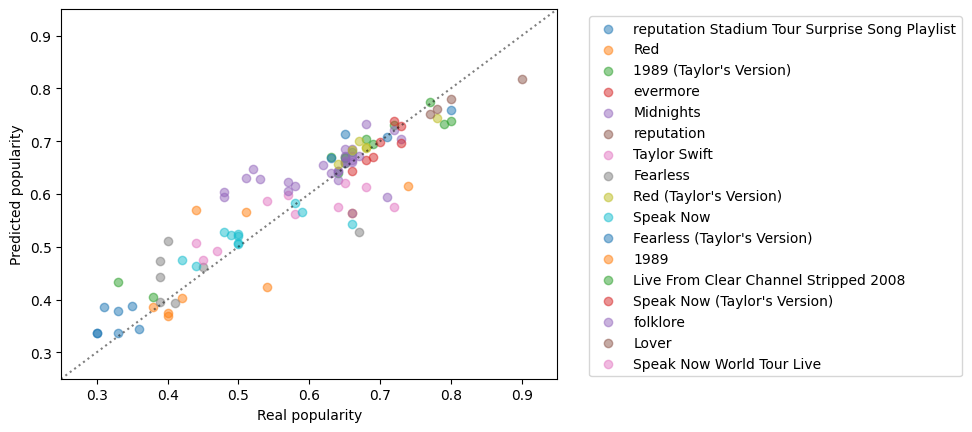

In [46]:
best_gb_params = results_df.loc[[results_df['mean_test_score'].idxmax()]]
best_gb_params = best_gb_params.drop(['mean_test_score', 'mean_train_score'], axis=1)
best_gb_params_dict = best_gb_params.iloc[0,:].to_dict()
best_gb_params_dict = {k.replace('param_', ''): v for k, v in best_gb_params_dict.items()}
print(best_gb_params_dict)
best_gb = GradientBoostingRegressor(**best_gb_params_dict)
best_gb.fit(X_train, y_train)
plot_predictions(best_gb)

In [47]:
importances = grid_search.best_estimator_.feature_importances_
pd.DataFrame(importances, index=X_train.columns, columns=['importance']).sort_values(by='importance', ascending=False)

,importance
performed_live,0.350331
Red,0.146932
taylors_version,0.082070
Fearless,0.079186
not_first_release,0.053066
loudness,0.051060
reputation,0.035112
Speak Now,0.031327
Lover,0.026946
track_number,0.023930


we can see that performed live is very important, and that not_first_release is also pretty important. Some albums are much more important than others.

## Conclusion